In [33]:
import os
import glob
import torch
import minari

import matplotlib.pyplot as plt
import statistics as stat
import numpy as np
import seaborn as sns

import torch.nn.functional as F
from torch import nn, Tensor
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

from tqdm import tqdm
from natsort import natsorted

In [34]:
print(f"Torch version: {torch.__version__}")
print(f"Torch cuda version: {torch.version.cuda}")

Torch version: 2.6.0
Torch cuda version: 12.6


In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [36]:
def collate_fn(batch):
    '''
    Makes sure the observations are of necessary length, padding with last value when too short.
    '''
    observations = [torch.as_tensor(x.observations['observation']) for x in batch]
    lengths = torch.tensor([obs.shape[0] for obs in observations])  # Tensor of original lengths

    # Pad with zeros first
    padded_obs = torch.nn.utils.rnn.pad_sequence(observations, batch_first=True)

    # Use advanced indexing to replace padding with the last valid value
    mask = torch.arange(padded_obs.shape[1]).expand(len(batch), -1) >= lengths.unsqueeze(1)
    padded_obs[mask] = padded_obs[torch.arange(len(batch)), lengths - 1].unsqueeze(1).expand_as(padded_obs)[mask]

    return {
        "observations": padded_obs
    }

In [37]:
dataset = minari.load_dataset('D4RL/pointmaze/medium-v2')
print(f"Total amount of episodes: {dataset.total_episodes}")  # 13210 episodes
batch_size = 64

dataLoader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
for batch in dataLoader:
    test_batch = batch['observations']
    print(f"test_batch.shape: {test_batch.shape}")
    break

# Storing 100 batches to display versus results of sampling.
observation_lst = []
max_batches = 100
for count, batch in enumerate(dataLoader):
    if count == max_batches:
        break
    obs = batch['observations']
    observation_lst.append(obs)

Total amount of episodes: 4752
test_batch.shape: torch.Size([64, 460, 4])


## Dataset trajectory example
* One episode
* Based on the 'Observation' parameter of Observations.

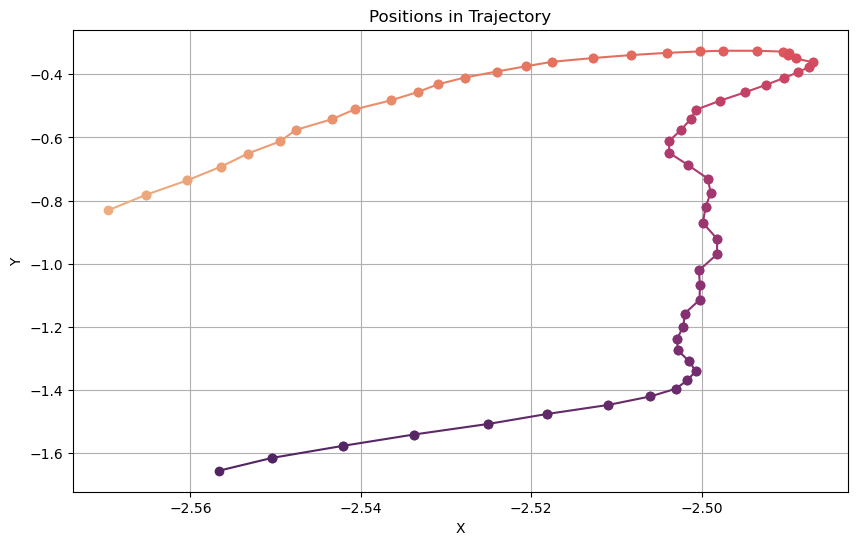

In [38]:
colors = sns.color_palette("flare", len(test_batch))

plt.figure(figsize=(10, 6))
for i in range(len(test_batch) - 1): # Traj plot
    plt.plot(test_batch[0, i:i+2, 0].cpu().numpy(), test_batch[0, i:i+2, 1].cpu().numpy(), color=colors[i], marker='o')
plt.title('Positions in Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()

plt.show()

## Diffusion

In [39]:
lr = 3e-3
traj_len = test_batch.size(1) # number of steps in the trajectory

In [40]:
class Diffusion:
    def __init__(self, traj_len, device, noise_steps=1000, beta_start=1e-4, beta_end=0.02):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.traj_len = traj_len
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1 - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)  # Cumulative product

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_trajs(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None]
        epsilon = torch.randn_like(x).to(self.device)
        x_noised = sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * epsilon
        return x_noised, epsilon

    @torch.no_grad()
    def sample(self, model, num_samples=5):
        """Reverse the diffusion process to generate samples."""
        model.eval()  # Set to evaluation mode

        save_dir_diff = "Sampling_Plots_Diff"
        os.makedirs(save_dir_diff, exist_ok=True)

        plot_every = self.noise_steps // 10  # Save images at 10% intervals
        snapshots_samples = []

        # Initialize noise
        x = torch.randn((num_samples, 4, self.traj_len), device=self.device)

        for i in tqdm(reversed(range(1, self.noise_steps)), position=0, desc="Sampling"):
            t = torch.full((x.shape[0],), i, device=self.device, dtype=torch.long)  # Time step

            predicted_noise = model(x)  # Predict noise
            alpha_t = self.alpha[i].view(1, 1, 1).to(self.device)
            alpha_hat_t = self.alpha_hat[i].view(1, 1, 1).to(self.device)

            if i > 1:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)  # No noise on the final step

            # Reverse diffusion step (Step 4 in DDPM Algorithm 2)
            x = (x - (1 - alpha_t).sqrt() * predicted_noise) / alpha_t.sqrt() + (self.beta[i].sqrt() * noise)

            # Save snapshots for visualization
            if i % plot_every == 0:
                renamed_step = self.noise_steps - i
                snapshots_samples.append(x.clone())

                plt.figure(figsize=(8, 6))
                plt.plot(x[0, 0, :].cpu().numpy(), x[0, 1, :].cpu().numpy(), label=f"Step {renamed_step}")
                # for observations in observation_lst:
                #     plt.plot(observations[0, :, 0].cpu().numpy(), observations[0, :, 1].cpu().numpy(), color='g', alpha=0.5)
                plt.title(f'Sampling Progression (Step {renamed_step})')
                plt.xlabel('X Position')
                plt.ylabel('Y Position')
                plt.legend()
                plt.grid()

                renamed_step = self.noise_steps - i
                save_path = os.path.join(save_dir_diff, f"sampling_step_{renamed_step}.png")
                plt.savefig(save_path)
                plt.close()

        model.train()
        return x


## UNet

In [41]:
class ConvBlock(nn.Module):
    """
    A simple convolutional block that applies:
      - Conv1d -> GroupNorm -> GELU -> Conv1d -> GroupNorm
    This block helps in feature extraction and stabilizes training.
    """
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1, bias=False), # First convolution: transforms input channels to out_channels
            nn.GroupNorm(1, out_channels), # Group normalization helps to normalize the output independently of batch size
            nn.GELU(), # Instead of ReLU, might not matter
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, bias=False), # Num channels kept constant
            nn.GroupNorm(1, out_channels)
        )
    
    def forward(self, x):
        return self.conv(x)


class DownSample(nn.Module):
    """
    Downsampling is done using a strided convolution which halves the sequence length.
    """
    def __init__(self, channels):
        super(DownSample, self).__init__()
        self.down = nn.Conv1d(channels, channels, kernel_size=4, stride=2, padding=1)
    
    def forward(self, x):
        return self.down(x)


class UpSample(nn.Module):
    """
    Upsampling is performed using a transposed convolution which doubles the sequence length.
    """
    def __init__(self, channels):
        super(UpSample, self).__init__()
        self.up = nn.ConvTranspose1d(channels, channels, kernel_size=4, stride=2, padding=1)
    
    def forward(self, x):
        return self.up(x)


class UNet1D(nn.Module):
    """
    A simplified 1D U-Net architecture.
    
    The network consists of:
      1. An encoder: A series of convolutional blocks with downsampling that extract features while reducing resolution.
      2. A bottleneck: A convolutional block at the lowest resolution.
      3. A decoder: Upsampling blocks that gradually recover the original resolution, each combining with the corresponding encoder's skip connection.
      4. A final convolution that maps features back to the desired number of output channels.
      
    Args:
        in_channels (int): Number of channels in the input (e.g., 1 for a single trajectory feature).
        
        base_channels (int): Number of channels in the first layer. Channels are typically doubled after each downsampling.
        num_layers (int): Number of down/up sampling layers.
    """
    def __init__(self, in_channels, n_feat, base_channels=64, num_layers=3):
        super(UNet1D, self).__init__()
        self.num_layers = num_layers
        self.in_channels = in_channels
        self.n_feat = n_feat
        
        # Encoder: Downsampling path
        self.down_blocks = nn.ModuleList()
        self.down_samples = nn.ModuleList()
        
        # Initial convolution
        self.initial_conv = ConvBlock(in_channels, base_channels)
        channels = base_channels  # current number of channels
        
        # Series of downsampling blocks
        for i in range(num_layers):
            self.down_blocks.append(ConvBlock(channels, channels * 2))
            self.down_samples.append(DownSample(channels * 2))
            channels *= 2  # update channels after each block
        
        self.bottleneck = ConvBlock(channels, channels)
        
        # Decoder: Upsampling path
        self.up_blocks = nn.ModuleList()
        self.up_samples = nn.ModuleList()
        
        for i in range(num_layers):
            self.up_samples.append(UpSample(channels))
            # After upsampling, we concatenate the features from the corresponding encoder block.
            # --> the input to the conv block is channels (from the upsampled feature) + channels//2 (from the skip connection).
            self.up_blocks.append(ConvBlock(channels + channels // 2, channels // 2))
            channels //= 2  # halve the number of channels as we move upward
        
        self.final_conv = nn.Conv1d(base_channels, n_feat, kernel_size=1)
    
    def forward(self, x):
        """
        Forward pass through the U-Net.
        
        Args:
            x (tensor): Input tensor of shape (batch, in_channels, T)
        
        Returns:
            tensor: Output tensor of shape (batch, out_channels, T)
        """

        skip_connections = []
        
        # Initial convolution before entering the encoder
        x = self.initial_conv(x)
        skip_connections.append(x)  # save for skip connection
        
        for conv_block, down in zip(self.down_blocks, self.down_samples):
            x = conv_block(x)            # Feature extraction
            skip_connections.append(x)   # Save the output for the decoder
            x = down(x)                  # Reduce temporal resolution
        
        x = self.bottleneck(x)
        
        # Reverse skip connections to use them in the decoder in the correct order.
        skip_connections = skip_connections[::-1]

        for idx, (up, conv_block) in enumerate(zip(self.up_samples, self.up_blocks)):
            x = up(x)  # Increase temporal resolution
            # Retrieve the corresponding skip connection from the encoder.
            # We start from index 1 because index 0 is the very first layer.
            skip = skip_connections[idx + 1]
            # If the upsampled feature and skip connection don't match in temporal size,
            # pad the upsampled feature.
            if x.size(-1) != skip.size(-1):
                diff = skip.size(-1) - x.size(-1)
                x = F.pad(x, (0, diff))
            # Concatenate along the channel dimension
            x = torch.cat([skip, x], dim=1)
            # Process the combined features
            x = conv_block(x)
        
        x = self.final_conv(x)
        return x
    

## Training

In [42]:
def train(device, dataLoader, lr, traj_len, epochs=15, batch_size=64):
    model = UNet1D(in_channels=4, n_feat=4).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    diffusion = Diffusion(traj_len, device, noise_steps = 1000, beta_start = 1e-4, beta_end = 0.02)
    mse = nn.MSELoss()

    losses = []

    for batch in tqdm(dataLoader, desc = "Training Progress"):
        observations = batch['observations']
        x = observations.to(device) #[torch.randint(observations.size(0), (batch_size, ))].to(device)
        sampled_t_steps = torch.randint(0, traj_len, (x.size(0),), dtype=torch.long, device=device) # Usikker på bruken av randint her
        x_t, noise = diffusion.noise_trajs(x, sampled_t_steps)

        # Permutate to [batch, features, num_points]
        noise = noise.permute(0, 2, 1).to(device, dtype=torch.float32) 
        x_t = x_t.permute(0, 2, 1).to(device=device, dtype=torch.float32) 

        predicted_noise = model(x_t)
        loss = mse(noise, predicted_noise)

        optimizer.zero_grad()
        loss.backward()
        loss.to(device, dtype=torch.float32)
        optimizer.step()
        losses.append(loss.item())
    
    return losses, model

In [43]:
losses, model = train(device, dataLoader, lr, traj_len)

Training Progress:   0%|          | 0/74 [00:00<?, ?it/s]

Training Progress: 100%|██████████| 74/74 [01:21<00:00,  1.10s/it]


In [44]:
diffusion = Diffusion(traj_len=traj_len, device=device)
samples = diffusion.sample(model, num_samples=20)

Sampling: 999it [00:10, 99.71it/s] 


In [45]:
def display_images_in_pairs(save_dir):
    """
    Display images with filenames matching 'sampling_step_*.png' in natural order, two at a time.

    Args:
        save_dir (str): Directory containing the images.
    """
    image_files = natsorted(glob.glob(os.path.join(save_dir, "sampling_step_*.png")))

    for i in range(0, len(image_files), 2):
        plt.figure(figsize=(12, 6))

        for j in range(2):
            if i + j < len(image_files):
                img = plt.imread(image_files[i + j])

                plt.subplot(1, 2, j + 1)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Step {image_files[i + j].split('_')[-1].split('.')[0]}")

        plt.show()

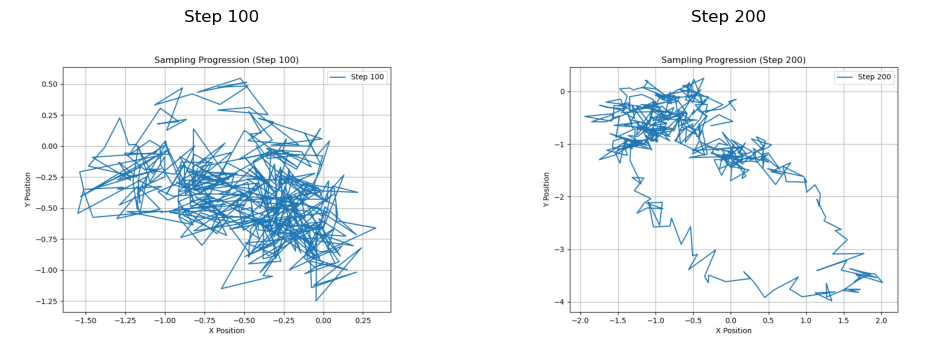

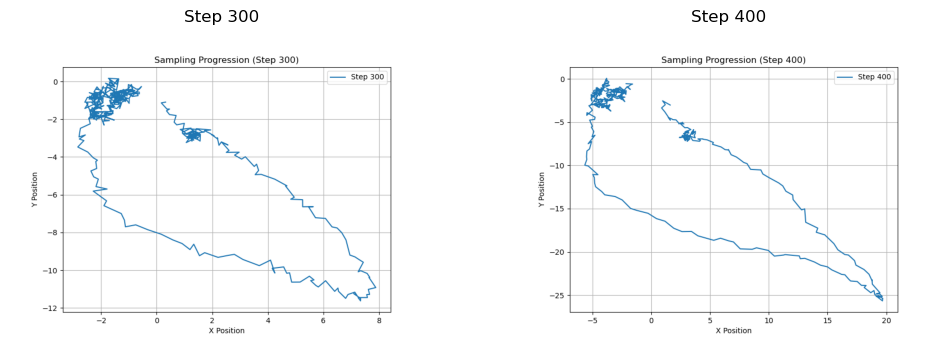

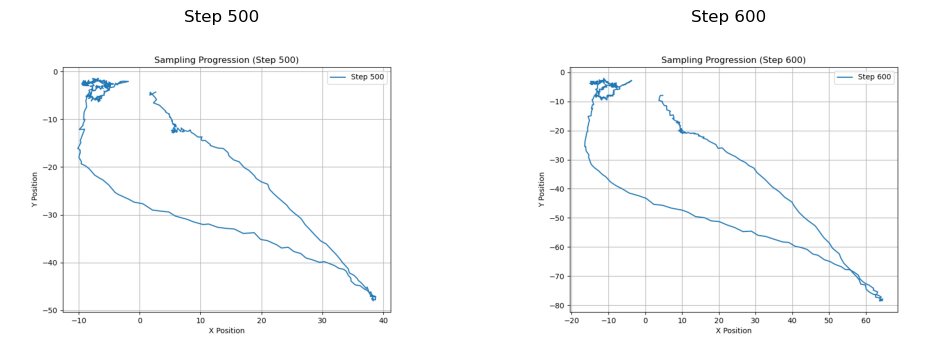

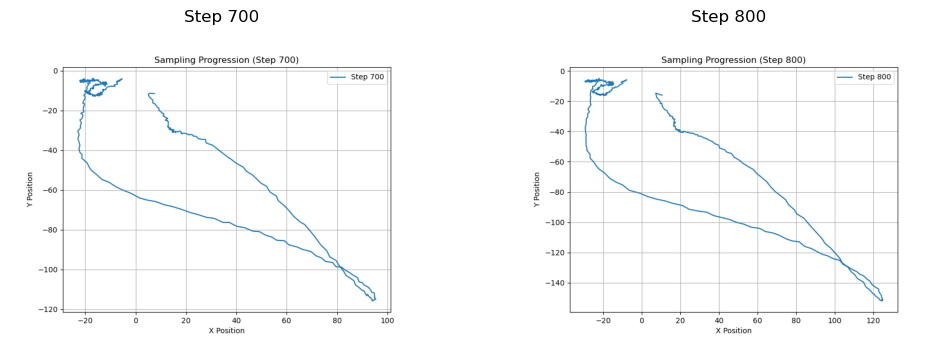

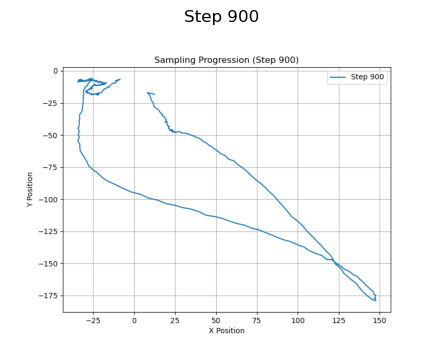

In [46]:
save_dir_diff = "Sampling_Plots_Diff"
display_images_in_pairs(save_dir_diff)

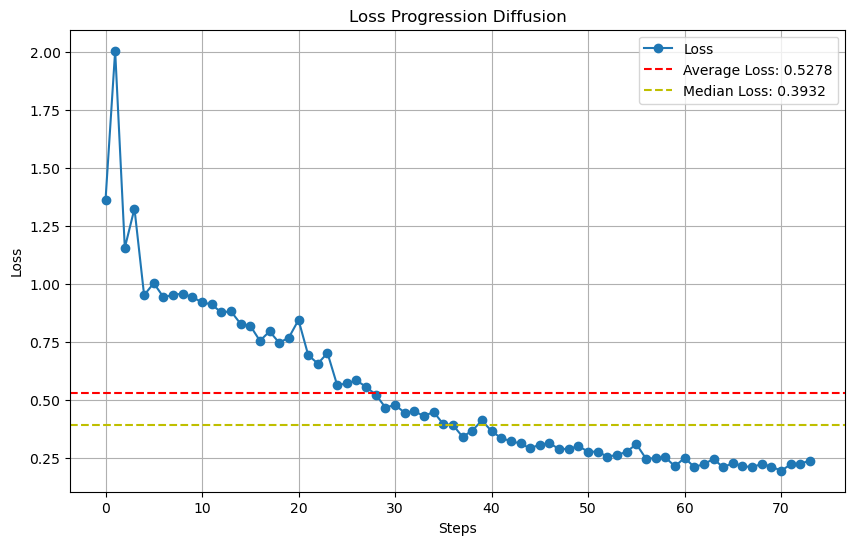

In [47]:
avg_loss = sum(losses)/len(losses)
med_loss = stat.median(losses)

save_dir = 'Plotted loss'
os.makedirs(save_dir, exist_ok=True)
plot_path = os.path.join(save_dir, 'loss_plot_diff.png')

plt.figure(figsize=(10, 6))
plt.plot(losses, label='Loss', marker='o')
plt.axhline(y=avg_loss, color='r', linestyle='--', label=f'Average Loss: {avg_loss:.4f}')
plt.axhline(y=med_loss, color='y', linestyle='--', label=f'Median Loss: {med_loss:.4f}')
plt.title('Loss Progression Diffusion')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(plot_path)
plt.show()